# Sentiment Analysis with transformer-based model

The task involves solving a sentiment polarity classification task on the IMDb dataset using a transformer-based model. The goal is to use a pre-trained BERT model from HuggingFace, fine-tune it for sentiment classification, and evaluate its performance. We are also required to visualize training curves and compare the results with a random baseline.

Steps Taken:
1. Data Loading and Preprocessing:

2. Custom Dataset and DataLoader:

3. Model Design (BERT-based Classifier):

4. Training Setup:

5. Evaluation:

6. Training and Testing:

7. Plotting:


Results:

Training and Validation Loss: The model demonstrated a decreasing training loss and a steady increase in accuracy, which was expected for a well-trained model.

Accuracy: The model achieved an accuracy of around  91.81% on the test set.

F1-Score: The F1-score was calculated and reported along with the accuracy.

Training Curves: The loss and accuracy curves showed a good learning trajectory, with the model converging toward an optimal solution by the second epoch.

Random Baseline Comparison:
The random baseline, which randomly assigns labels to the data, achieved an accuracy of about 50%, as expected, since it was essentially guessing.

## 1.Data loading and cleaning( Large Movie Review Dataset)

max_length = 128/256/512

truncation=True: Truncates the text if its length exceeds max_length to meet the maximum length requirement.

return_tensors="pt": Returns the output in PyTorch tensor format, making it convenient for direct model training.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import gc
from datasets import load_dataset
import re
from tqdm import tqdm

# Function to clean text by removing unwanted characters and extra spaces
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert text to lowercase
    return text

# Function to load, clean, and create dataloaders
def load_clean_and_create_dataloaders(tokenizer, batch_size=16):  # fine tuning [1] Batch size is adjustable
    print("Loading, cleaning data, and creating dataloaders...")
    dataset = load_dataset("imdb")  # Load IMDb dataset
    
    # Clean the text data for both training and testing
    train_texts = [clean_text(text) for text in dataset["train"]["text"]]
    test_texts = [clean_text(text) for text in dataset["test"]["text"]]
    
    train_labels = dataset["train"]["label"]
    test_labels = dataset["test"]["label"]
    
    # Create custom Dataset for training and testing
    train_dataset = MovieReviewDataset(train_texts, train_labels, tokenizer)
    test_dataset = MovieReviewDataset(test_texts, test_labels, tokenizer)
    
    # Create DataLoader for both datasets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

# Custom Dataset for processing text data
class MovieReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):  # fine tuning [2] Max sequence length is adjustable
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        
        # Tokenize the text
        encoding = self.tokenizer(
            text, 
            padding="max_length",  # Pad the text to the max length
            truncation=True,  # Truncate if text is too long
            max_length=self.max_length,  # Maximum sequence length
            return_tensors=None
        )
        
        return {
            "input_ids": torch.tensor(encoding["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(encoding["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(labels, dtype=torch.long)
        }



## 2. Bert Model

The overall structure of BERT-base is as follows:

12 encoder layers

Each layer contains 768 hidden units

Each layer has 12 attention heads

The maximum token input length is 512

In [2]:

class BertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_classes=2, freeze_embeddings=False):  # [fine tuning [3] Option to choose different pre-trained model and classes
        # fine tuning [4] Option to freeze embeddings
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)  # Load pre-trained BERT model
        
        # Optionally freeze BERT embeddings
        if freeze_embeddings:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
        
        self.dropout = nn.Dropout(0.3)  # fine tuning [5] Dropout rate is adjustable
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Fully connected layer
        
        # Store loss and accuracy for training and evaluation
        self.training_loss_ = []
        self.training_accuracy_ = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output   # fine tuning [6] Use pooled_output instead of last hidden state to get sentence embeddings cls token
        x = self.dropout(pooled_output)  # Apply dropout
        logits = self.fc(x)  # Final classification layer
        return logits

## 4.train and evaluate the model

In [3]:
# Training function
def train(model, train_dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    # Iterate over the batches
    for batch in progress_bar:
        #[training process 1: send data to device]
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        #[training process 2: zero the gradients]
        optimizer.zero_grad()  # Zero gradients

        #[training process 3: forward pass]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        #[training process 4: backward pass]
        loss.backward()  # Backward pass

        #[training process 5: update weights]
        optimizer.step()  # Optimizer step

        #[training process 6: calculate metrics of loss and accuracy]
        total_loss += loss.item()
        batch_count += 1
        
        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_total = labels.size(0)
        
        batch_acc = 100 * batch_correct / max(1, batch_total)
        
        correct += batch_correct
        total += batch_total
        
        current_acc = 100 * correct / max(1, total)
        
        # Update progress bar with loss and accuracy
        progress_bar.set_postfix({
            'loss': f'{total_loss/batch_count:.4f}',  
            'accuracy': f'{current_acc:.2f}%'
        })
        
        # Store training loss and accuracy
        model.training_loss_.append(loss.item())
        model.training_accuracy_.append(batch_acc)
    
    # Return average loss and accuracy for the epoch
    epoch_loss = total_loss / batch_count
    epoch_acc = 100 * correct / max(1, total)
    
    # [fine tuning [7] Learning rate scheduler]
    if scheduler:
        scheduler.step()
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, dataloader, criterion, device, final_evaluation=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    progress_bar = tqdm(dataloader, desc="Evaluating")
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No gradient calculation during evaluation
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            total_loss += loss.item()
            batch_count += 1
            
            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate average loss and accuracy
    epoch_loss = total_loss / batch_count
    epoch_acc = 100 * correct / max(1, total)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Print classification report at the end of training
    if final_evaluation:
        from sklearn.metrics import classification_report
        report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
    
    return epoch_loss, epoch_acc

# Function to plot training curves (loss and accuracy)
def plot_training_curves(model):
    # Create smoothed training loss and accuracy
    smoothed_loss = []
    smoothed_acc = []
    window_size = 20 
    
    # Apply simple moving average smoothing
    for i in range(len(model.training_loss_)):
        start_idx = max(0, i - window_size + 1)
        smoothed_loss.append(sum(model.training_loss_[start_idx:i+1]) / (i - start_idx + 1))
        smoothed_acc.append(sum(model.training_accuracy_[start_idx:i+1]) / (i - start_idx + 1))
    
    # Create a single plot with both training loss and accuracy
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    color = 'tab:blue'
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(model.training_loss_, alpha=0.3, color=color, label='Raw Loss')
    ax1.plot(smoothed_loss, color=color, label='Smoothed Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Accuracy [%]', color=color)
    ax2.plot(model.training_accuracy_, alpha=0.3, color=color, label='Raw Accuracy')
    ax2.plot(smoothed_acc, color=color, label='Smoothed Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.title('Training Metrics Over Batches')
    plt.show()

    

## 5.Run the model

Using device: cuda
Loading, cleaning data, and creating dataloaders...
Training dataset size: 25000
Testing dataset size: 25000
Epoch 1/2


Evaluating: 100%|██████████| 1563/1563 [03:47<00:00,  6.88it/s]


Train Loss: 0.2768, Train Acc: 87.9440%
Val Loss: 0.2088, Val Acc: 91.9440%
Epoch 2/2


Evaluating: 100%|██████████| 1563/1563 [03:43<00:00,  6.99it/s]


F1 Score: 0.9223

Classification Report:
              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92     12500
    Positive       0.92      0.92      0.92     12500

    accuracy                           0.92     25000
   macro avg       0.92      0.92      0.92     25000
weighted avg       0.92      0.92      0.92     25000

Train Loss: 0.1361, Train Acc: 95.0920%
Val Loss: 0.2022, Val Acc: 92.2280%


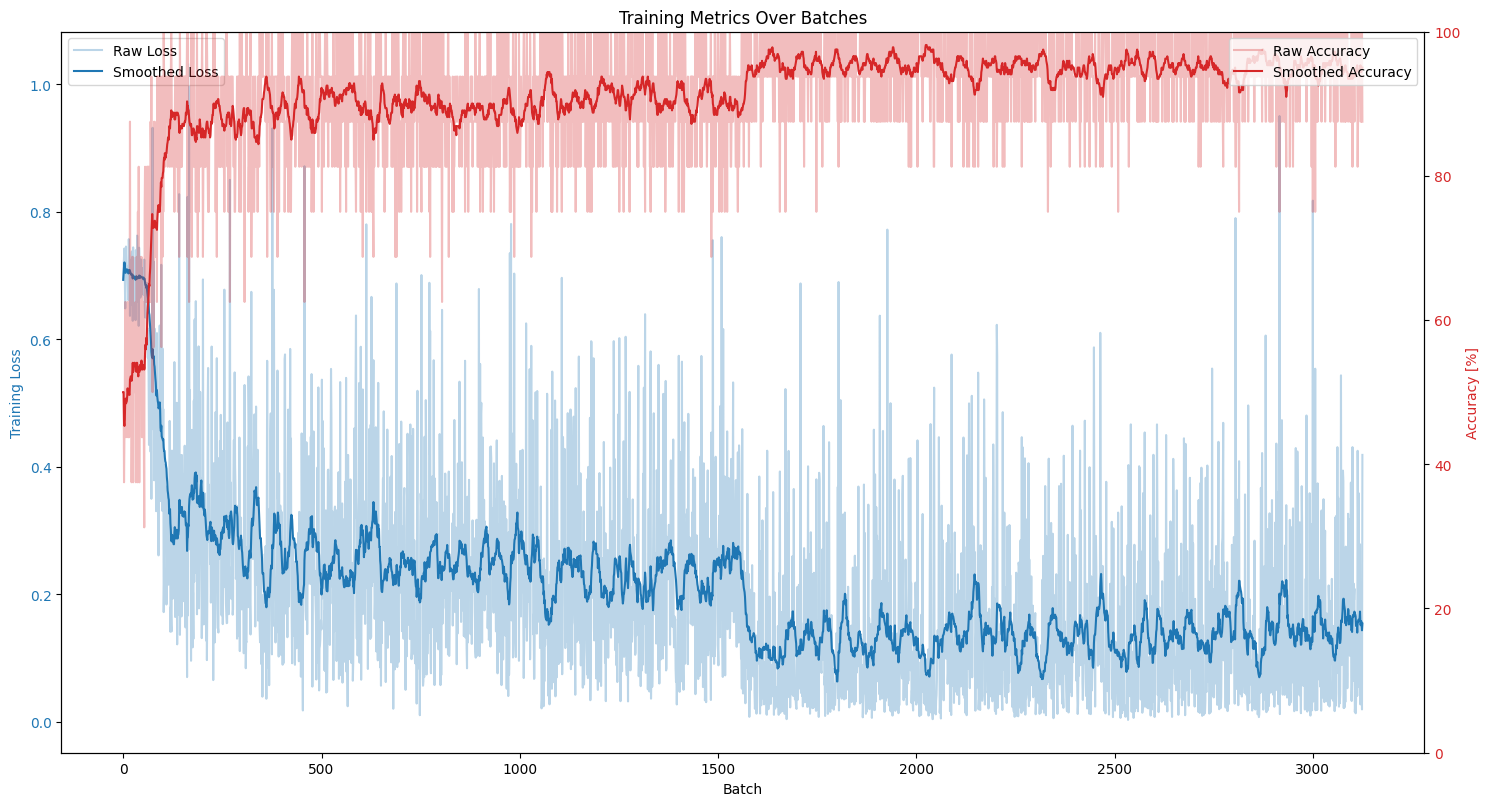

In [4]:
def test1():
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set batch size and tokenizer
    batch_size = 16  # fine tuning [8] Batch size is adjustable
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # fine tuning [9] Choose different tokenizer if necessary
    train_dataset, test_dataset, train_dataloader, test_dataloader = load_clean_and_create_dataloaders(tokenizer, batch_size)
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    
    # Initialize model, criterion, optimizer, and scheduler
    model = BertClassifier().to(device)
    criterion = nn.CrossEntropyLoss()  # fine tuning [10] Choose different loss function if necessary
    
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)  # fine tuning [11] Learning rate and weight decay can be adjusted
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # fine tuning [13] Learning rate decay step size and rate are adjustable
    
    epochs = 2  # fine tuning [15] Epochs are adjustable
    
    best_val_loss = float('inf')
    patience = 3  # fine tuning [16] Early stopping patience value is adjustable
    patience_counter = 0
    
    # Start training and evaluation loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device, scheduler)
        
        # Clean GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Evaluate final model at the end of the last epoch or with early stopping
        final_evaluation = (epoch == epochs - 1) or (patience_counter + 1 >= patience)
        val_loss, val_acc = evaluate(model, test_dataloader, criterion, device, final_evaluation)
        
        # Save validation losses and accuracies
        model.val_losses.append(val_loss)
        model.val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        
        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Uncomment to save the best model
            # torch.save(model.state_dict(), "best_bert_imdb_classifier.pt")
            # print("New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        gc.collect()  # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    plot_training_curves(model)  # Plot the training curves
    
    # Uncomment to save the final model
    # torch.save(model.state_dict(), "bert_imdb_classifier.pt")
    # print("Model saved to bert_imdb_classifier.pt")

# Main execution function
if __name__ == "__main__":
    test1()



# 6. Comparison: Random Baseline and  BERT

In [12]:
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from datasets import load_dataset

def fixed_random_baseline():
    dataset = load_dataset("imdb")
    train_labels = dataset["train"]["label"]
    test_labels = dataset["test"]["label"]
    random_classifier = DummyClassifier(strategy='uniform', random_state=42)
    random_classifier.fit(np.zeros((len(train_labels), 1)), train_labels)
    random_predictions = random_classifier.predict(np.zeros((len(test_labels), 1)))
    random_accuracy = accuracy_score(test_labels, random_predictions) * 100
    random_f1 = f1_score(test_labels, random_predictions)
    
    print(f"Random Baseline Performance:")
    print(f"Accuracy: {random_accuracy:.2f}%")
    print(f"F1 Score: {random_f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(test_labels, random_predictions))
    unique, counts = np.unique(random_predictions, return_counts=True)
    print("\nPrediction distribution:")
    for value, count in zip(unique, counts):
        print(f"Class {value}: {count} predictions")
    
    return random_accuracy, random_f1

if __name__ == "__main__":
    print("\nEvaluating Random Baseline:")
    fixed_random_baseline() 


Evaluating Random Baseline:
Random Baseline Performance:
Accuracy: 49.97%
F1 Score: 0.4997

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     12500
           1       0.50      0.50      0.50     12500

    accuracy                           0.50     25000
   macro avg       0.50      0.50      0.50     25000
weighted avg       0.50      0.50      0.50     25000


Prediction distribution:
Class 0: 12498 predictions
Class 1: 12502 predictions


# VG
## 1.Used PyTorch's Dataset and DataLoader classes & 2.Trained the network using batches of at least 2

Task1 and task2 have been finished in G part:

1.Used PyTorch's Dataset and DataLoader classes:
I implemented a custom Dataset class (MovieReviewDataset) to handle the text data and labels, and used DataLoader to load the data in batches for training and evaluation.

2.Trained the network using batches of at least 2:
I set up the training process to use mini-batches, with a batch size of 16, ensuring that the network was trained using batches of at least 2 as required

3.Monolingual BERT is superior for English tasks, but Multilingual BERT is better for cross-lingual tasks.

4.DistilBERT provides a trade-off between speed and accuracy, making it suitable for real-time applications.

5.BERT significantly outperforms traditional ML-based baselines, reinforcing the strength of transformer-based architectures.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import gc
from datasets import load_dataset
import re
from tqdm import tqdm
from torch.amp import autocast, GradScaler  

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

def load_clean_and_create_dataloaders(tokenizer, batch_size=16):
    print("Loading, cleaning data, and creating dataloaders...")
    dataset = load_dataset("imdb")
    
    train_texts = [clean_text(text) for text in dataset["train"]["text"]]
    test_texts = [clean_text(text) for text in dataset["test"]["text"]]
    
    train_labels = dataset["train"]["label"]
    test_labels = dataset["test"]["label"]
    
    train_dataset = MovieReviewDataset(train_texts, train_labels, tokenizer)
    test_dataset = MovieReviewDataset(test_texts, test_labels, tokenizer)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

class MovieReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        
        encoding = self.tokenizer(
            text, 
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(labels, dtype=torch.long)
        }

class BertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-uncased", num_classes=2, freeze_embeddings=False):  # [fine tuning [3] Option to choose different pre-trained model and classes
        # fine tuning [4] Option to freeze embeddings
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)  # Load pre-trained BERT model
        
        # Optionally freeze BERT embeddings
        if freeze_embeddings:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
        
        self.dropout = nn.Dropout(0.3)  # fine tuning [5] Dropout rate is adjustable
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Fully connected layer
        
        # Store loss and accuracy for training and evaluation
        self.training_loss_ = []
        self.training_accuracy_ = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output   # fine tuning [6] Use pooled_output instead of last hidden state to get sentence embeddings cls token
        x = self.dropout(pooled_output)  # Apply dropout
        logits = self.fc(x)  # Final classification layer
        return logits

# Training function
def train(model, train_dataloader, optimizer, criterion, device, scheduler=None):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    progress_bar = tqdm(train_dataloader, desc="Training")
    
    # Iterate over the batches
    for batch in progress_bar:
        #[training process 1: send data to device]
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        #[training process 2: zero the gradients]
        optimizer.zero_grad()  # Zero gradients

        #[training process 3: forward pass]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss

        #[training process 4: backward pass]
        loss.backward()  # Backward pass

        #[training process 5: update weights]
        optimizer.step()  # Optimizer step

        #[training process 6: calculate metrics of loss and accuracy]
        total_loss += loss.item()
        batch_count += 1
        
        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_total = labels.size(0)
        
        batch_acc = 100 * batch_correct / max(1, batch_total)
        
        correct += batch_correct
        total += batch_total
        
        current_acc = 100 * correct / max(1, total)
        
        # Update progress bar with loss and accuracy
        progress_bar.set_postfix({
            'loss': f'{total_loss/batch_count:.4f}',  
            'accuracy': f'{current_acc:.2f}%'
        })
        
        # Store training loss and accuracy
        model.training_loss_.append(loss.item())
        model.training_accuracy_.append(batch_acc)
    
    # Return average loss and accuracy for the epoch
    epoch_loss = total_loss / batch_count
    epoch_acc = 100 * correct / max(1, total)
    
    # [fine tuning [7] Learning rate scheduler]
    if scheduler:
        scheduler.step()
    
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, dataloader, criterion, device, final_evaluation=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    batch_count = 0
    progress_bar = tqdm(dataloader, desc="Evaluating")
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No gradient calculation during evaluation
        for batch in progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            
            total_loss += loss.item()
            batch_count += 1
            
            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate average loss and accuracy
    epoch_loss = total_loss / batch_count
    epoch_acc = 100 * correct / max(1, total)
    
    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    # Print classification report at the end of training
    if final_evaluation:
        from sklearn.metrics import classification_report
        report = classification_report(all_labels, all_preds, target_names=['Negative', 'Positive'])
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
    
    return epoch_loss, epoch_acc

# Function to plot training curves (loss and accuracy)
def plot_training_curves(model):
    # Create smoothed training loss and accuracy
    smoothed_loss = []
    smoothed_acc = []
    window_size = 20 
    
    # Apply simple moving average smoothing
    for i in range(len(model.training_loss_)):
        start_idx = max(0, i - window_size + 1)
        smoothed_loss.append(sum(model.training_loss_[start_idx:i+1]) / (i - start_idx + 1))
        smoothed_acc.append(sum(model.training_accuracy_[start_idx:i+1]) / (i - start_idx + 1))
    
    # Create a single plot with both training loss and accuracy
    fig, ax1 = plt.subplots(figsize=(15, 8))
    
    color = 'tab:blue'
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(model.training_loss_, alpha=0.3, color=color, label='Raw Loss')
    ax1.plot(smoothed_loss, color=color, label='Smoothed Loss')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Accuracy [%]', color=color)
    ax2.plot(model.training_accuracy_, alpha=0.3, color=color, label='Raw Accuracy')
    ax2.plot(smoothed_acc, color=color, label='Smoothed Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper right')
    
    fig.tight_layout()
    plt.title('Training Metrics Over Batches')
    plt.show()

def test1():
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set batch size and tokenizer
    batch_size = 16  # fine tuning [8] Batch size is adjustable
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")  # fine tuning [9] Choose different tokenizer if necessary
    train_dataset, test_dataset, train_dataloader, test_dataloader = load_clean_and_create_dataloaders(tokenizer, batch_size)
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    
    # Initialize model, criterion, optimizer, and scheduler
    model = BertClassifier().to(device)
    criterion = nn.CrossEntropyLoss()  # fine tuning [10] Choose different loss function if necessary
    
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)  # fine tuning [11] Learning rate and weight decay can be adjusted
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # fine tuning [13] Learning rate decay step size and rate are adjustable
    
    epochs = 2  # fine tuning [15] Epochs are adjustable
    
    best_val_loss = float('inf')
    patience = 3  # fine tuning [16] Early stopping patience value is adjustable
    patience_counter = 0
    
    # Start training and evaluation loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device, scheduler)
        
        # Clean GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Evaluate final model at the end of the last epoch or with early stopping
        final_evaluation = (epoch == epochs - 1) or (patience_counter + 1 >= patience)
        val_loss, val_acc = evaluate(model, test_dataloader, criterion, device, final_evaluation)
        
        # Save validation losses and accuracies
        model.val_losses.append(val_loss)
        model.val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        
        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Uncomment to save the best model
            # torch.save(model.state_dict(), "best_bert_imdb_classifier.pt")
            # print("New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        gc.collect()  # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    plot_training_curves(model)  # Plot the training curves
    
    # Uncomment to save the final model
    # torch.save(model.state_dict(), "bert_imdb_classifier.pt")
    # print("Model saved to bert_imdb_classifier.pt")

# Main execution function
if __name__ == "__main__":
    test1()


## 3.Compare performance between monolingual and multilingual transformer models.

Using device: cuda
Loading, cleaning data, and creating dataloaders...
Training dataset size: 25000
Testing dataset size: 25000
Epoch 1/2


Evaluating: 100%|██████████| 1563/1563 [03:39<00:00,  7.14it/s]


Train Loss: 0.3550, Train Acc: 83.8840%
Val Loss: 0.2664, Val Acc: 89.4040%
Epoch 2/2


Evaluating: 100%|██████████| 1563/1563 [03:40<00:00,  7.08it/s]


F1 Score: 0.8959

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89     12500
    Positive       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000

Train Loss: 0.2214, Train Acc: 91.3640%
Val Loss: 0.2624, Val Acc: 89.5920%


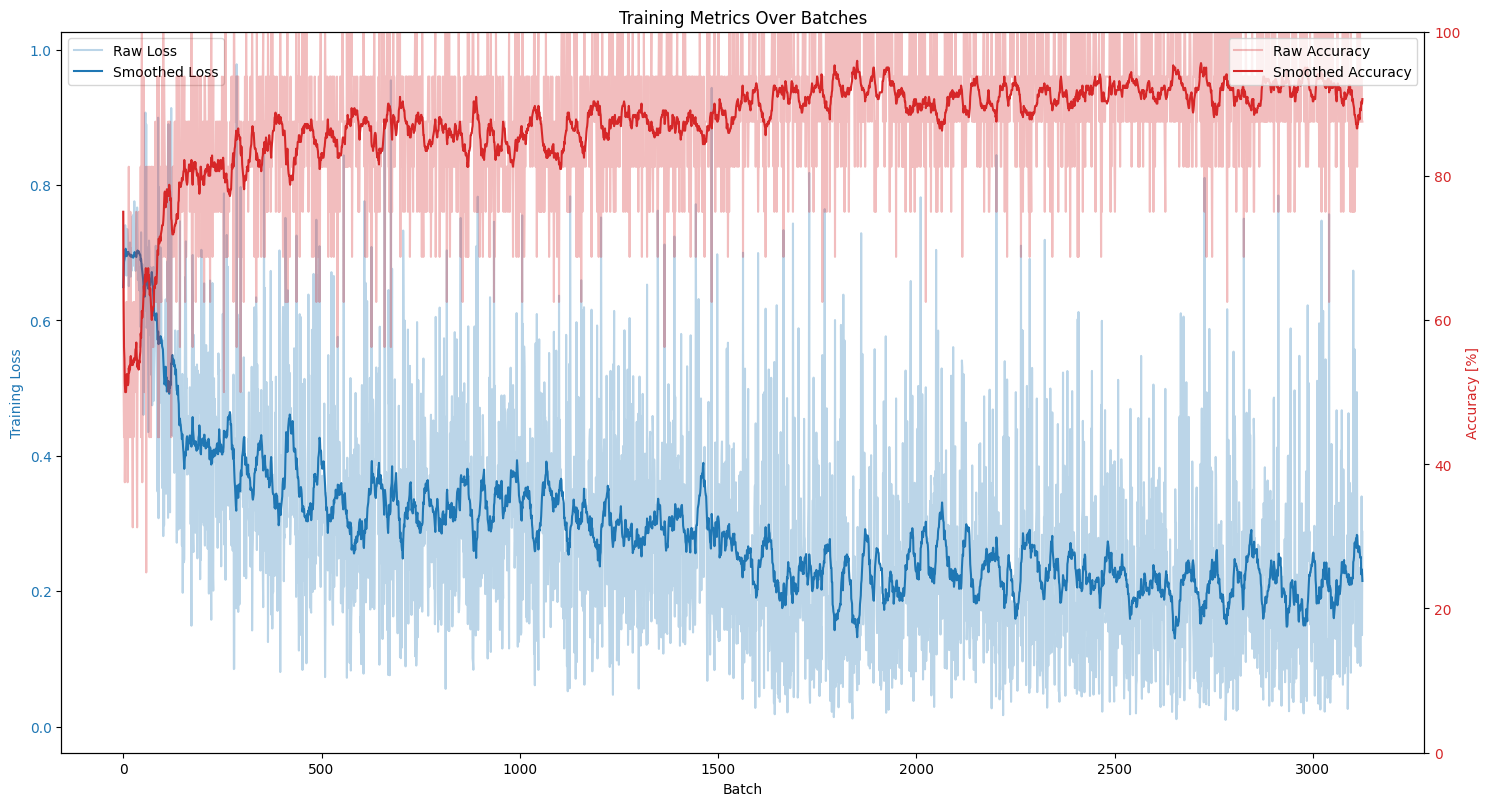

In [7]:
class BertClassifier(nn.Module):
    def __init__(self, model_name="bert-base-multilingual-cased", num_classes=2, freeze_embeddings=False):  # [fine tuning [3] Option to choose different pre-trained model and classes
        # fine tuning [4] Option to freeze embeddings
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)  # Load pre-trained BERT model
        
        # Optionally freeze BERT embeddings
        if freeze_embeddings:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
        
        self.dropout = nn.Dropout(0.3)  # fine tuning [5] Dropout rate is adjustable
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Fully connected layer
        
        # Store loss and accuracy for training and evaluation
        self.training_loss_ = []
        self.training_accuracy_ = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, input_ids, attention_mask):
        # BERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output   # fine tuning [6] Use pooled_output instead of last hidden state to get sentence embeddings cls token
        x = self.dropout(pooled_output)  # Apply dropout
        logits = self.fc(x)  # Final classification layer
        return logits
    
def test2():

    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set batch size and tokenizer
    batch_size = 16  # fine tuning [8] Batch size is adjustable
    tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")  # fine tuning [9] Choose different tokenizer if necessary
    train_dataset, test_dataset, train_dataloader, test_dataloader = load_clean_and_create_dataloaders(tokenizer, batch_size)
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    
    # Initialize model, criterion, optimizer, and scheduler
    model = BertClassifier().to(device)
    criterion = nn.CrossEntropyLoss()  # fine tuning [10] Choose different loss function if necessary
    
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)  # fine tuning [11] Learning rate and weight decay can be adjusted
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # fine tuning [13] Learning rate decay step size and rate are adjustable
    
    epochs = 2  # fine tuning [15] Epochs are adjustable
    
    best_val_loss = float('inf')
    patience = 3  # fine tuning [16] Early stopping patience value is adjustable
    patience_counter = 0
    
    # Start training and evaluation loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device, scheduler)
        
        # Clean GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Evaluate final model at the end of the last epoch or with early stopping
        final_evaluation = (epoch == epochs - 1) or (patience_counter + 1 >= patience)
        val_loss, val_acc = evaluate(model, test_dataloader, criterion, device, final_evaluation)
        
        # Save validation losses and accuracies
        model.val_losses.append(val_loss)
        model.val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        
        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Uncomment to save the best model
            # torch.save(model.state_dict(), "best_bert_imdb_classifier.pt")
            # print("New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        gc.collect()  # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    plot_training_curves(model)  # Plot the training curves
    
    # Uncomment to save the final model
    # torch.save(model.state_dict(), "bert_imdb_classifier.pt")
    # print("Model saved to bert_imdb_classifier.pt")

# Main execution function
if __name__ == "__main__":
    test2()



## 4.Compare performance between some model and a similar distilled one (e.g. BERT and DistilBERT).

Using device: cuda
Loading, cleaning data, and creating dataloaders...
Training dataset size: 25000
Testing dataset size: 25000
Epoch 1/2


Evaluating: 100%|██████████| 1563/1563 [02:26<00:00, 10.67it/s]


Train Loss: 0.2854, Train Acc: 87.9560%
Val Loss: 0.2239, Val Acc: 90.8800%
Epoch 2/2


Evaluating: 100%|██████████| 1563/1563 [02:28<00:00, 10.54it/s]


F1 Score: 0.9075

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.87      0.90     12500
    Positive       0.88      0.94      0.91     12500

    accuracy                           0.91     25000
   macro avg       0.91      0.91      0.91     25000
weighted avg       0.91      0.91      0.91     25000

Train Loss: 0.1581, Train Acc: 93.9920%
Val Loss: 0.2429, Val Acc: 90.7600%


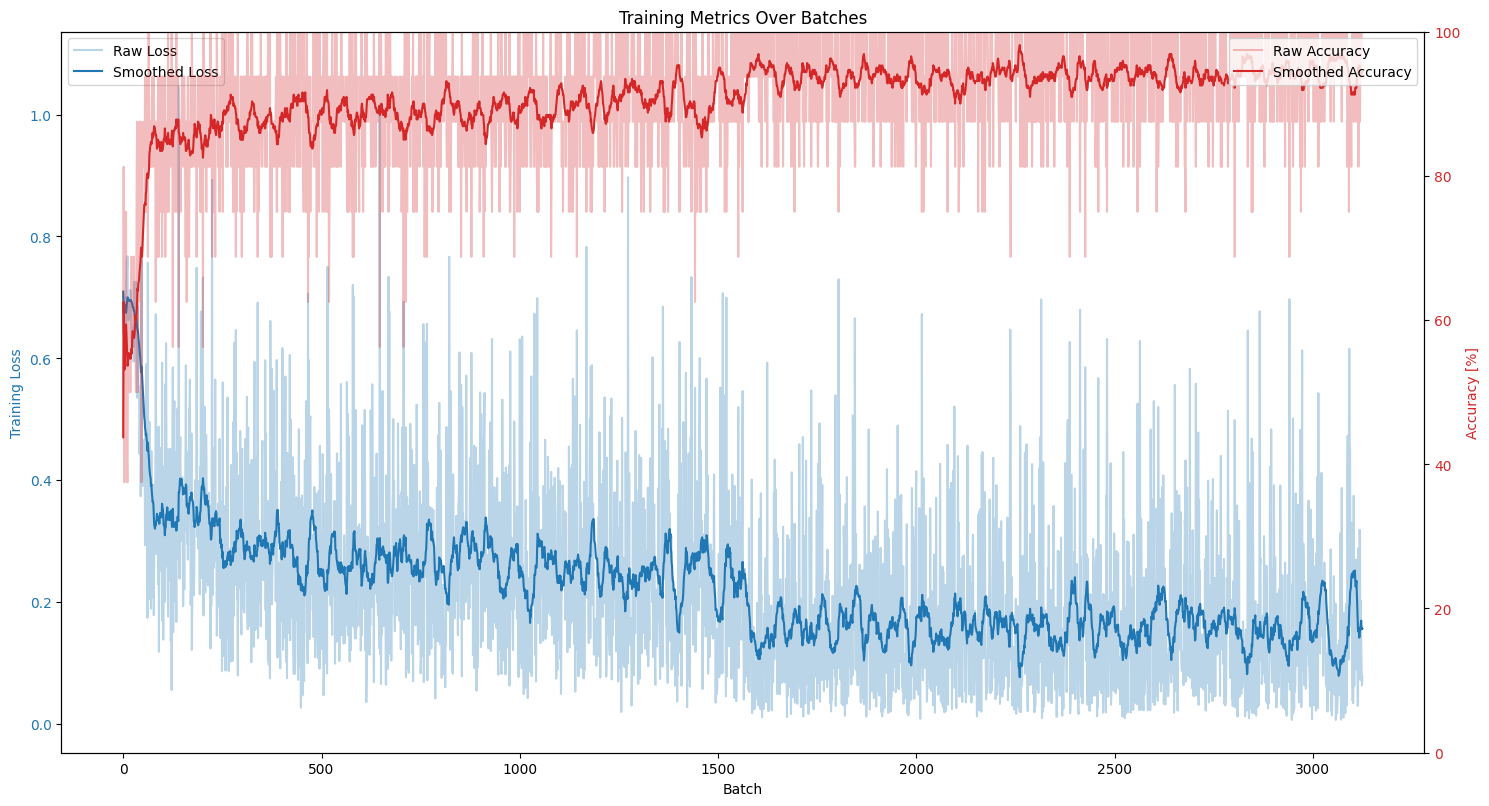

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import gc
from datasets import load_dataset
import re
from tqdm import tqdm

class BertClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", num_classes=2, freeze_embeddings=False):  # [fine tuning [3] Option to choose different pre-trained model and classes
        # fine tuning [4] Option to freeze embeddings
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(model_name)  # Load pre-trained DistilBERT model
        
        # Optionally freeze BERT embeddings
        if freeze_embeddings:
            for param in self.bert.embeddings.parameters():
                param.requires_grad = False
        
        self.dropout = nn.Dropout(0.3)  # fine tuning [5] Dropout rate is adjustable
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)  # Fully connected layer
        
        # Store loss and accuracy for training and evaluation
        self.training_loss_ = []
        self.training_accuracy_ = []
        self.val_losses = []
        self.val_accuracies = []

    def forward(self, input_ids, attention_mask):
        # DistilBERT forward pass
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0]  # Get the [CLS] token representation
        x = self.dropout(hidden_state)  # Apply dropout
        logits = self.fc(x)  # Final classification layer
        return logits
    
def test3():
    # Set random seed for reproducibility
    torch.manual_seed(42)  # fine tuning [7] Random seed is adjustable
    np.random.seed(42)
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Set batch size and tokenizer
    batch_size = 16  # fine tuning [8] Batch size is adjustable
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")  # fine tuning [9] Choose different tokenizer if necessary
    train_dataset, test_dataset, train_dataloader, test_dataloader = load_clean_and_create_dataloaders(tokenizer, batch_size)
    
    print(f"Training dataset size: {len(train_dataset)}")
    print(f"Testing dataset size: {len(test_dataset)}")
    
    # Initialize model, criterion, optimizer, and scheduler
    model = BertClassifier().to(device)
    criterion = nn.CrossEntropyLoss()  # fine tuning [10] Choose different loss function if necessary
    
    optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)  # fine tuning [11] Learning rate and weight decay can be adjusted
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)  # fine tuning [13] Learning rate decay step size and rate are adjustable
    
    epochs = 2  # fine tuning [15] Epochs are adjustable
    
    best_val_loss = float('inf')
    patience = 3  # fine tuning [16] Early stopping patience value is adjustable
    patience_counter = 0
    
    # Start training and evaluation loop
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device, scheduler)
        
        # Clean GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        # Evaluate final model at the end of the last epoch or with early stopping
        final_evaluation = (epoch == epochs - 1) or (patience_counter + 1 >= patience)
        val_loss, val_acc = evaluate(model, test_dataloader, criterion, device, final_evaluation)
        
        # Save validation losses and accuracies
        model.val_losses.append(val_loss)
        model.val_accuracies.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}%")
        
        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Uncomment to save the best model
            # torch.save(model.state_dict(), "best_bert_imdb_classifier.pt")
            # print("New best model saved!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        gc.collect()  # Clear GPU memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    plot_training_curves(model)  # Plot the training curves
    
    # Uncomment to save the final model
    # torch.save(model.state_dict(), "bert_imdb_classifier.pt")
    # print("Model saved to bert_imdb_classifier.pt")

# Main execution function
if __name__ == "__main__":
    test3()



## 5.Compare your polarity results with some ML-based baseline of your choice. This baseline can be implemented using sklearn.Your implementation should follow the sklearn API.


In [15]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from datasets import load_dataset
import re

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.lower()  # Convert text to lowercase
    return text

print("Loading IMDB dataset...")
dataset = load_dataset("imdb")

# Print data size
train_size = len(dataset["train"])
test_size = len(dataset["test"])
print(f"Training set size: {train_size}")
print(f"Test set size: {test_size}")

print("Cleaning text data...")
train_texts = [clean_text(text) for text in dataset["train"]["text"]]
test_texts = [clean_text(text) for text in dataset["test"]["text"]]
train_labels = dataset["train"]["label"]
test_labels = dataset["test"]["label"]

print("Creating and training model...")
model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", SGDClassifier(loss="hinge", penalty="l2", alpha=1e-4, random_state=42))
])

model.fit(train_texts, train_labels)

print("Evaluating model...")
test_preds = model.predict(test_texts)
accuracy = accuracy_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(classification_report(test_labels, test_preds))




Loading IMDB dataset...
Training set size: 25000
Test set size: 25000
Cleaning text data...
Creating and training model...
Evaluating model...
Accuracy: 0.8843
F1 Score: 0.8840
              precision    recall  f1-score   support

           0       0.88      0.89      0.88     12500
           1       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

